Found 275 audio files.


Text(0, 0.5, 'amplitude')

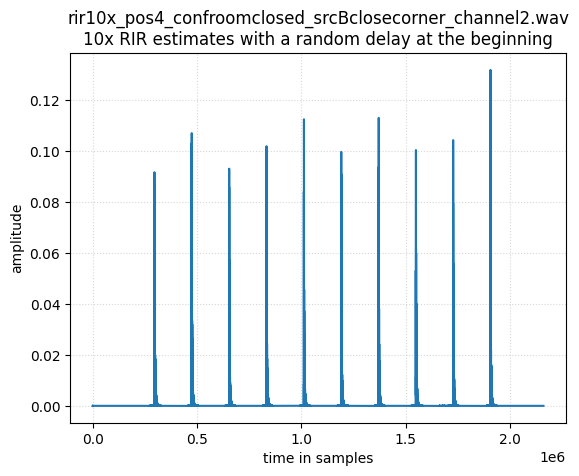

In [1]:
import os
import glob
import soundfile as sf
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

path_audio_conv = "deconvolved_audio_recs"

# List all audio files in the directory
audio_files = glob.glob(os.path.join(path_audio_conv, "*.wav"))
print(f"Found {len(audio_files)} audio files.")

file_path=random.choice(audio_files)
audio, samplerate = sf.read(file_path)

plt.figure()
# plt.plot(np.abs(audio[280000:320000]))
plt.plot(np.abs(audio))
plt.grid(True, ls=':', alpha=0.5)
plt.title(f"{os.path.basename(file_path)}\n10x RIR estimates with a random delay at the beginning")
plt.xlabel("time in samples")
plt.ylabel("amplitude")


In [176]:
from get_sweep import get_validation_sweep

_, _, T, fs = get_validation_sweep()

275it [00:04, 58.85it/s]


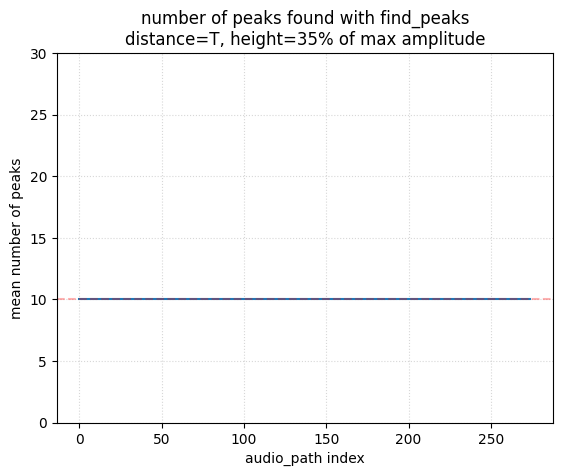

In [205]:
from tqdm import tqdm

my_list=[]
for i, file_path in tqdm(enumerate(audio_files)):
    audio, samplerate = sf.read(file_path)
    n_peak_list=[]
    height=np.absolute(audio).max()*0.35
    peaks, _ = find_peaks(audio, distance=T, height=height)
    my_list.append(len(peaks))

npeaks=np.array(my_list).flatten()

plt.plot(npeaks)
plt.title("number of peaks found with find_peaks\ndistance=T, height=35% of max amplitude")
plt.axhline(y = 10, color = 'r', linestyle = '--', alpha=0.3) 
plt.ylim(0,30)
plt.xlabel("audio_path index")
plt.ylabel("mean number of peaks")
plt.grid(True, ls=':', alpha=0.5)
plt.show()

It seems like the one of the ideal values to find 10 peaks for every audio recording is distance=T, and height=35% of max amplitude. (The peaks will be separated by at least an ESS and be non-noise)